In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from tqdm.auto import tqdm

# !pip install kornia
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import kornia
import mediapy as media

In [28]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def to_numpy(t):
    return t.detach().cpu().numpy()

In [29]:
# SRC: https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata/blob/master/lib/CAModel.py
class CAModel(nn.Module):
    def __init__(self, channel_n, fire_rate, device, hidden_size=128):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fc0 = nn.Linear(channel_n * 3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        init.zeros_(self.fc1.weight)

        self.fire_rate = fire_rate
        self.to(self.device)

    def alive(self, x):
        return F.max_pool2d(x[:, :1, :, :], kernel_size=3, stride=1, padding=1) > 0.1

    def perceive(self, x, angle):
        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1, 1, 3, 3).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle * np.pi / 180)
        s = np.sin(angle * np.pi / 180)
        w1 = c * dx - s * dy
        w2 = s * dx + c * dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x, y1, y2), 1)
        return y

    def update(self, x, fire_rate, angle):
        x = x.transpose(1, 3)
        pre_life_mask = self.alive(x)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1, 3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate = self.fire_rate
        stochastic = torch.rand([dx.size(0), dx.size(1), dx.size(2), 1]) > fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        x = x + dx.transpose(1, 3)

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        return x.transpose(1, 3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0):
        x = x.transpose(1, 3)
        seq = [x.transpose(1, 3)]
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
            seq.append(x.transpose(1, 3))
        return seq

In [30]:
class Decoder(nn.Module):
    def __init__(self, hid, seed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size=5, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, seed_size),
        )

    def forward(self, x):
        return self.net(x)

In [31]:
CHANS = 32
FIRE_RATE = 0.0
device = "cuda"
HIDDEN_SIZE = 128
DECODER_HID = 128
BS = 32
SIZE = 32 # W,H
LR = 0.001

In [32]:
im = torch.rand(32, 1, 32, 32).to(device)
decoder = Decoder(DECODER_HID, CHANS).to(device)
res = decoder(im)
res.shape

torch.Size([32, 32])

In [33]:
def plot_seq_stat(seq):
    m = to_numpy(torch.stack(seq).transpose(0, 1))
    b,s,c,h,w = m.shape
    merged = m.reshape(b,s,c*h*w)
    ma = abs(merged).max(axis=-1)
    mean = merged.mean(axis=-1)
    s = merged.sum(axis=-1)
    m = merged.max(axis=-1)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].set_title("sum")
    axs[1].set_title("max")
    for x in s:
        axs[0].plot(x, c="tab:blue", alpha=0.2)
    for x in m:
        axs[1].plot(x, c="tab:red", alpha=0.2)
    plt.tight_layout()
    plt.show()

In [34]:
model = CAModel(CHANS, FIRE_RATE, device=device, hidden_size=HIDDEN_SIZE)
decoder = Decoder(DECODER_HID, CHANS).to(device)

# Sanity check
inp = torch.rand(BS, CHANS, SIZE, SIZE).to(device)
seq = model(inp, steps=15)
last_frame = seq[-1]
last_frame_slice = last_frame[:, :1]
last_frame_slice.shape
decoded_hid = decoder(last_frame_slice)
decoded_hid.shape

torch.Size([32, 32])

In [36]:
# plot_seq_stat(seq)

In [81]:
noise = nn.Sequential(
    kornia.augmentation.RandomAffine(
        degrees=20,
        translate=[0.0, 0.01],
        scale=[0.9, 1.1],
        shear=[-5, 5],
        p=1,
    ),
    kornia.augmentation.RandomErasing(
        scale=(0.01, 0.02), ratio=(0.5, 2),
        value=0, p=1,
    ),
    kornia.augmentation.RandomGaussianNoise(0, 0.1, p=1),
).to(device)

In [82]:
screen = torch.rand(10, 16, 32, 32)
noised_screen = noise(screen)
noised_screen.shape

torch.Size([10, 16, 32, 32])

,,,,,,,,,

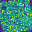
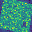
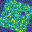
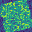
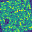
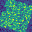
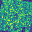
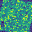
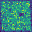
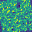

In [83]:
media.show_images(noised_screen[:, 0], border=True, height=150, cmap="viridis")

In [84]:
def generate_inputs(bs, chans, size):
    while True:
        screen = torch.zeros(bs, chans, size, size)
        seeds = torch.rand(bs, chans)
        seeds[:, chans//2:] = 1
        seeds[:, 0] = 1
        screen[:, :, size//2, size//2] = seeds

        yield screen, seeds

In [85]:
input_gen = generate_inputs(BS, CHANS, SIZE)
batch = next(input_gen)
screen, seeds = batch
screen.shape, seeds.shape

(torch.Size([32, 32, 32, 32]), torch.Size([32, 32]))

In [86]:
batch = next(input_gen)
screen, seeds = batch
screen, seeds = screen.to(device), seeds.to(device)

seq = model(screen, steps=15)
last_frame = seq[-1]
last_frame_slide = last_frame[:, :1]
noised_last_frame = noise(last_frame_slide)

decoded = decoder(noised_last_frame)
decoded.shape, seeds.shape

(torch.Size([32, 32]), torch.Size([32, 32]))

In [88]:
model = CAModel(CHANS, FIRE_RATE, device=device, hidden_size=HIDDEN_SIZE)
decoder = Decoder(DECODER_HID, CHANS).to(device)
input_gen = generate_inputs(BS, CHANS, SIZE)
history = []

Loss: 0.00476:   5%|4         | 2499/50000 [02:48<52:18, 15.14it/s]

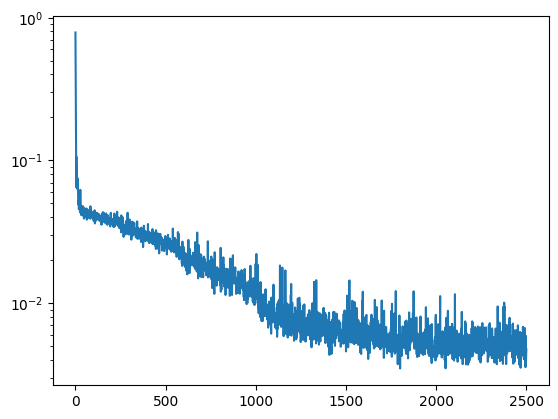

,,,,,,,,,

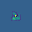
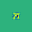
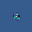
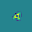
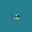
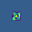
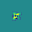
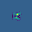
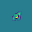
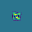

,,,,,,,,,

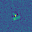
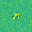
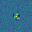
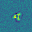
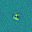
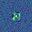
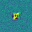
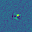
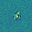
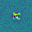

,,,,

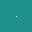
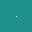
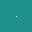
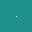
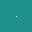

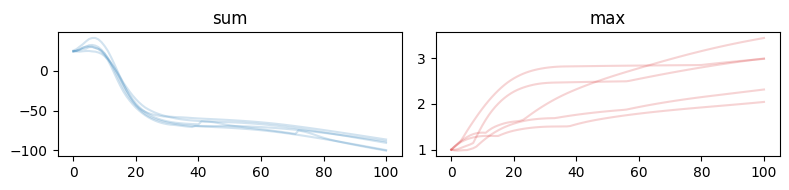

In [ ]:
optim = torch.optim.Adam([*model.parameters(), *decoder.parameters()], lr=LR)
pbar = tqdm(range(50_000))

for i in pbar:
    input_gen_small = generate_inputs(5, CHANS, SIZE)
    batch = next(input_gen)
    screen, seeds = batch

    S = np.random.randint(10, 100)

    seq = model(screen.to(device), steps=S)
    last_frame = seq[-1][:,:1]


    optim.zero_grad()
    loss = 0
    loss += F.mse_loss(decoder(noise(last_frame)), seeds[:, :].to(device))

    abs_frame = torch.abs(last_frame)
    peaks = abs_frame[abs_frame > 1.1] - 1.1
    if len(peaks) > 0:
        loss += peaks.mean() / 1000

    loss.backward()
    optim.step()
    history.append(loss.item())

    pbar.set_description(f"Loss: {loss.item():0.5f}")
    if i % 250 == 0:
        clear_output()

        display(pbar.container)

        plt.plot(history)
        plt.yscale("log")
        plt.show()

        media.show_images(
            to_numpy(seq[-1][:10])[:, 0], border=True, height=100, cmap="viridis", columns=10)
        media.show_images(
            to_numpy(noise(seq[-1][:10]))[:, 0], border=True, height=100, cmap="viridis", columns=10)
        
        input_gen_small = generate_inputs(5, CHANS, SIZE)
        batch = next(input_gen_small)
        screen, seeds = batch
        seq = model(screen.to(device), steps=100)
        media.show_videos(
            media.to_rgb(
                to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]),
                vmin=-1, vmax=1, cmap="viridis"
            ),
            height=150, fps=20, codec='gif', border=True, columns=16
        )
        plot_seq_stat(seq)

In [ ]:
plt.plot(history)
plt.yscale("log")
plt.show()

media.show_images(to_numpy(seq[-1][:10])[:, 0], border=True, height=100, cmap="viridis", columns=10)

input_gen_small = generate_inputs(5, CHANS, SIZE)
batch = next(input_gen_small)
screen, seeds = batch
seq = model(screen.to(device), steps=100)
media.show_videos(
    media.to_rgb(to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]), vmin=0, vmax=1, cmap="viridis"),
    height=150, fps=20, codec='gif', border=True, columns=16
)

In [ ]:
from datetime import datetime
import os

now = datetime.now()
save_dir = "./saved"
os.makedirs(save_dir, exist_ok=True)

nca_path = os.path.join(save_dir, f"nca_{now}.pkl")
decoder_path = os.path.join(save_dir, f"nca_{now}.pkl")

with open(nca_path) as fp:
    torch.save(mdoel, fp)
with open(decoder_path) as fp:
    torch.save(mdoel, fp)

In [ ]:
batch = next(input_gen)
screen, seeds = batch

S = np.random.randint(4, 50)

seq = model(screen.to(device), steps=100)

In [ ]:
media.show_videos(
    to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]),
    height=100, fps=8, codec='gif', border=True, columns=16
)

In [ ]:
input_gen_small = generate_inputs(5, CHANS, SIZE)
batch = next(input_gen_small)
screen, seeds = batch

S = 100

seq = model(screen.to(device), steps=S)
media.show_videos(
    media.to_rgb(to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]), vmin=0, vmax=1, cmap="viridis"),
    height=150, fps=20, codec='gif', border=True, columns=16
)

In [ ]:
batch = next(input_gen)
screen, seeds = batch

S = 50

seq = model(screen.to(device), steps=S // 2)
last_frame = seq[-1]
noised_last_frame = noise(last_frame)
normal_noise = torch.randn_like(noised_last_frame) / 30
# noised_last_frame += normal_noise

seq2 = model(noised_last_frame, steps=S // 2)

In [ ]:
media.show_videos(
    media.to_rgb(to_numpy(torch.stack(seq + seq2).transpose(0, 1)[:,:,0]), vmin=0, vmax=1, cmap="viridis"),
    height=100, fps=20, codec='gif', border=True, columns=16
)